# Setup

In [1]:
# Python 3 compatability
from __future__ import division, print_function

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
import scipy
from scipy import stats

# plotting
import matplotlib
from matplotlib import pyplot as plt

# fits data
from astropy.io import fits

# inline plotting
%matplotlib inline

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})

# HSC SynPipe

Plot comparisons to data from HSC Synpipe.

In [3]:
# convert from magnitudes to fluxes
def inv_magnitude(mag, err, zeropoints=1.):
    
    phot = 10**(-0.4 * mag) * zeropoints
    phot_err = err * 0.4 * np.log(10.) * phot
    
    return phot, phot_err

bands = ['G', 'R', 'I', 'Z', 'Y']
cpivot, mrange = 1e-4, 2.  # pivot point & mag range used to shift offsets
nmin = 10  # minimum number of objects required to plot results
boxcar = 6  # bins used for boxcar used to determine variance for plotting
mgrid = np.arange(18, 28., 0.15)  # magnitude bins
dmgrid = np.arange(-0.1, 0.1, 0.0075)  # dmag bins
dmpgrid = np.arange(-0.02, 0.02, 1e-5)  # dmag (predicted) bins

/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in less


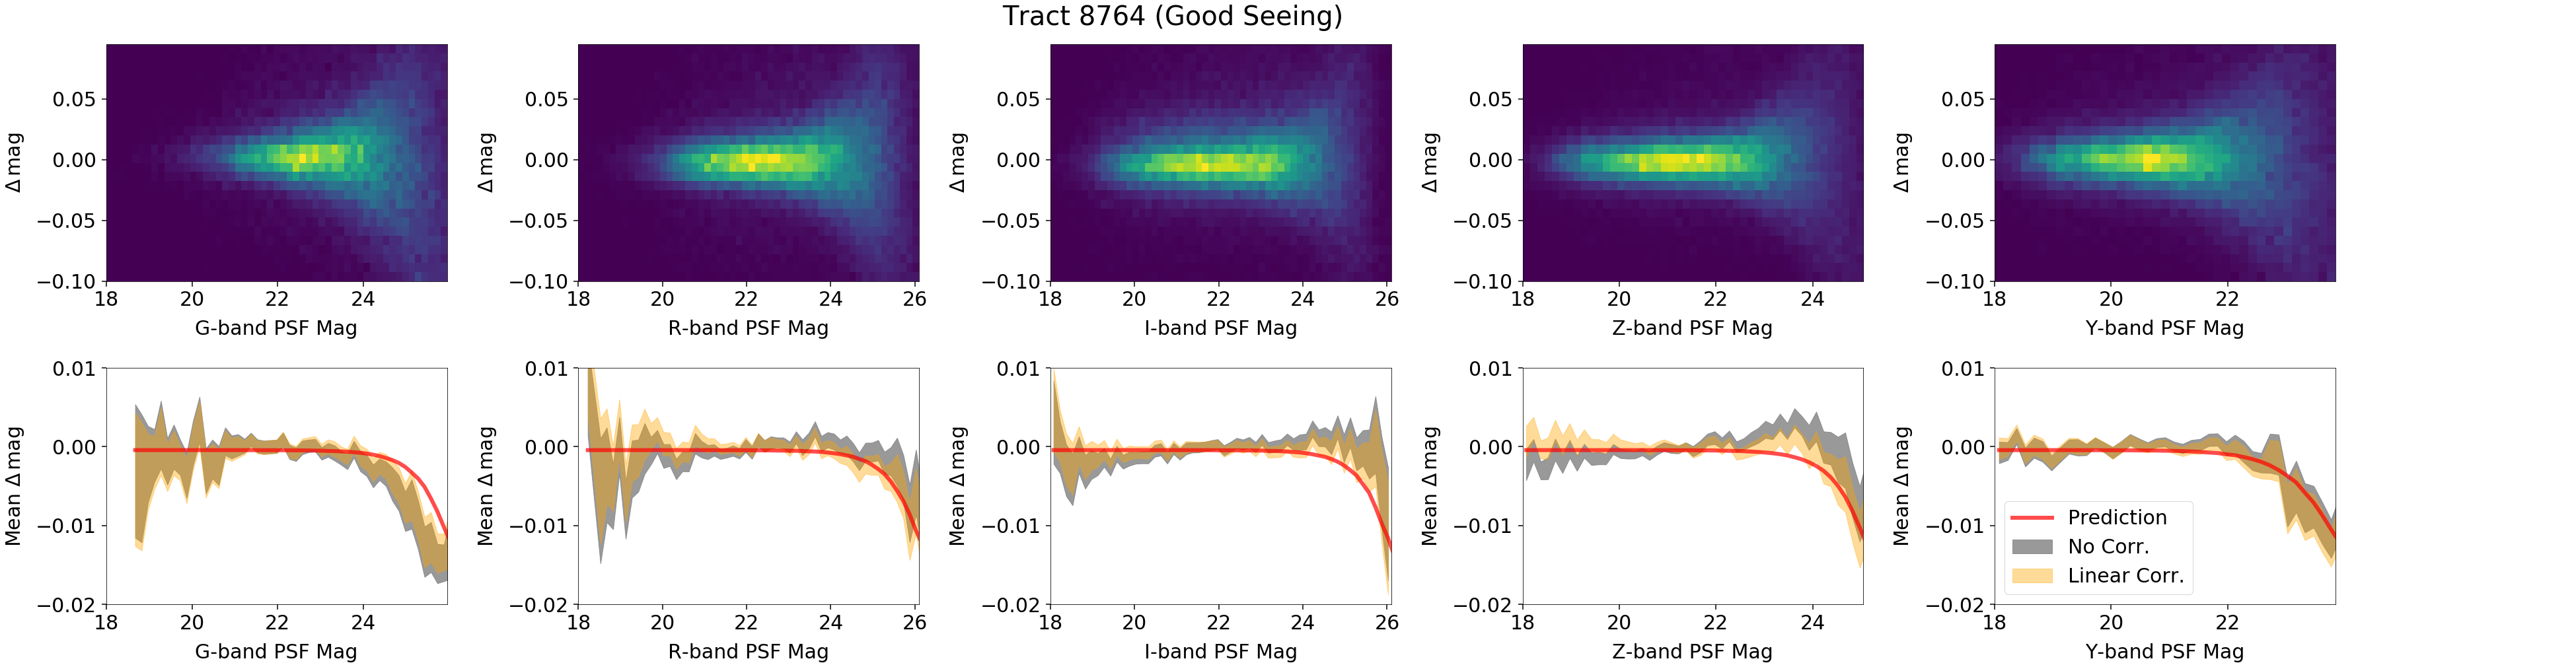

In [4]:
plt.figure(figsize=(50, 14))
plt.suptitle('Tract 8764 (Good Seeing)', y=1.02, fontsize=40)
for count, i in enumerate(bands):

    # load data
    data = fits.open('data/synpipe/star1_HSC-{0}_good.fits'.format(i))[1].data

    # top panel: dmag distribution (shifted)
    plt.subplot(2, 5, 1 + count)
    moff = np.median(data['mag'] - data['mag.psf'])
    n, bx, by, _ = plt.hist2d(data['mag'], 
                              data['mag.psf'] - data['mag'] + moff,
                              [mgrid, dmgrid])
    xc, yc = 0.5 * (bx[1:] + bx[:-1]), 0.5 * (by[1:] + by[:-1])  # bin centers
    nmag = np.sum(n, axis=1)  # counts per magnitude bin
    nmean = np.sum(yc * n, axis=1) / np.sum(n, axis=1)  # mean
    nstd = np.sqrt(np.sum((yc[None, :] - nmean[:, None])**2 * n, axis=1) / np.sum(n, axis=1))  # error

    # compute SNR as a function of magnitude
    mconst = 2.5 / np.log(10)
    fout, fe = inv_magnitude(data['mag.psf'], data['mag.psf.err'])
    fin, fe2 = inv_magnitude(data['mag'], data['mag.psf.apcorr.err'])
    snr = fout/np.sqrt(fe**2 + (0.02 * fout)**2)
    # first order
    n, bx, by = np.histogram2d(data['mag'], -mconst * snr**-2,
                               [mgrid, dmpgrid])
    xc, yc = 0.5 * (bx[1:] + bx[:-1]), 0.5 * (by[1:] + by[:-1])
    cmean = np.sum(yc * n, axis=1) / np.sum(n, axis=1)
    
    # prettify
    plt.xlabel('{0}-band PSF Mag'.format(i))
    plt.ylabel(r'$\Delta\,$mag')
    try:
        midx = np.where(cmean < -0.012)[0][0]
    except:
        midx = -1
        pass
    plt.xlim([mgrid[0], mgrid[midx]])
    plt.tight_layout()

    # bottom panel: computed mean offsets vs predicted mean offsets
    plt.subplot(2, 5, 6 + count)
    mhigh = xc[np.abs(cmean - np.nanmax(cmean)) > cpivot][0]
    mlow = mhigh - mrange
    nsel = nmag > nmin
    offset = np.nanmedian(nmean[(xc >= mlow) & (xc <= mhigh) & nsel])
    nmean_err = nstd/np.sqrt(nmag)
    nmean_serr = np.array([np.std(nmean[i:i+boxcar]) for i in range(len(nmean) - boxcar)])
    nmean_err[boxcar//2:-boxcar//2] = np.sqrt(nmean_err[boxcar//2:-boxcar//2]**2 + nmean_serr**2)
    plt.fill_between(xc[nsel], (nmean - offset - nmean_err)[nsel],
                     (nmean - offset + nmean_err)[nsel], color='gray', alpha=0.8)
    # apply linear bias correction
    lin_coeff = np.polyfit(xc[(xc >= mlow - 1) & (xc <= mhigh + 1) & nsel], 
                           nmean[(xc >= mlow - 1) & (xc <= mhigh + 1) & nsel], 1)
    lin_off = np.poly1d(lin_coeff)(xc)
    nmean -= lin_off
    offset = np.nanmedian(nmean[(xc >= mlow) & (xc <= mhigh) & nsel])
    plt.fill_between(xc[nsel], (nmean - offset - nmean_err)[nsel],
                     (nmean - offset + nmean_err)[nsel], color='orange', alpha=0.4)
    # plot prediction
    plt.plot(xc[nsel], cmean[nsel], lw=6, color='red', alpha=0.7)
    # prettify
    plt.xlabel('{0}-band PSF Mag'.format(i))
    plt.ylabel(r'Mean $\Delta\,$mag')
    try:
        midx = np.where(cmean < -0.012)[0][0]
    except:
        midx = -1
        pass
    plt.xlim([mgrid[0], mgrid[midx]])
    plt.ylim([-0.02, 0.01])
    plt.tight_layout()
plt.legend(['Prediction', 'No Corr.', 'Linear Corr.'])

# save figure
plt.savefig('plots/hsc_synpipe_goodseeing.png', bbox_inches='tight')

/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in less


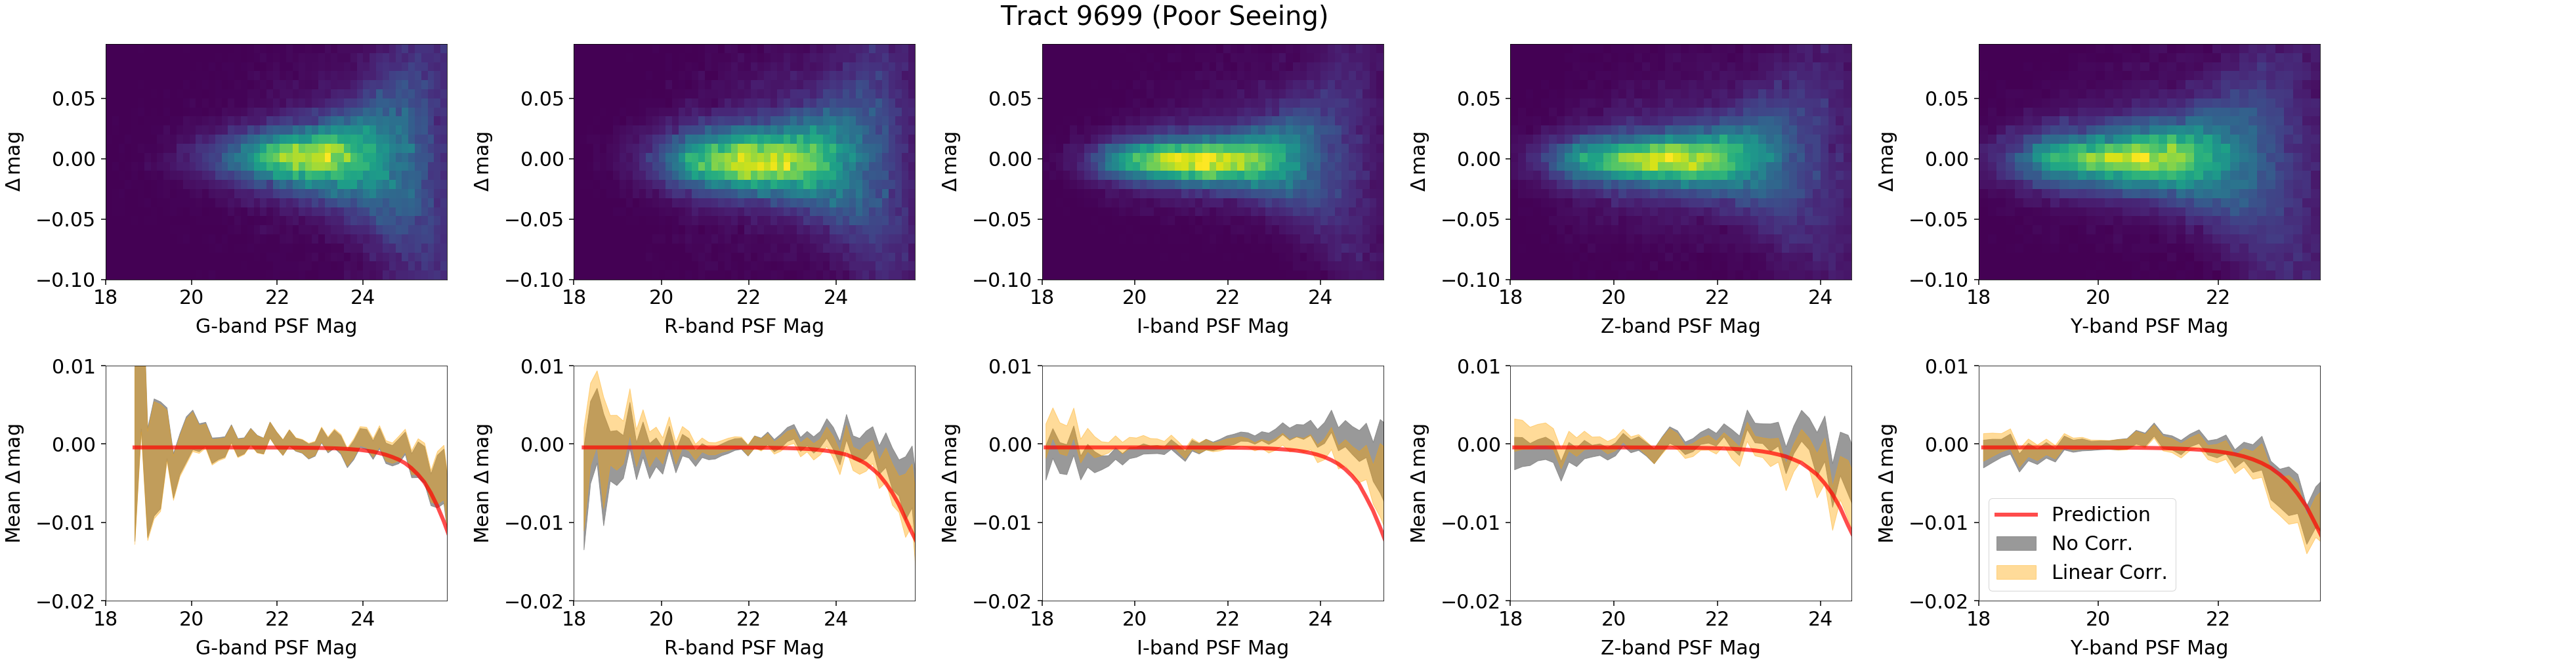

In [5]:
plt.figure(figsize=(50, 14))
plt.suptitle('Tract 9699 (Poor Seeing)', y=1.02, fontsize=40)
for count, i in enumerate(bands):

    # load data
    data = fits.open('data/synpipe/star2_HSC-{0}_good.fits'.format(i))[1].data

    # top panel: dmag distribution (shifted)
    plt.subplot(2, 5, 1 + count)
    moff = np.median(data['mag'] - data['mag.psf'])
    n, bx, by, _ = plt.hist2d(data['mag'], 
                              data['mag.psf'] - data['mag'] + moff,
                              [mgrid, dmgrid])
    xc, yc = 0.5 * (bx[1:] + bx[:-1]), 0.5 * (by[1:] + by[:-1])  # bin centers
    nmag = np.sum(n, axis=1)  # counts per magnitude bin
    nmean = np.sum(yc * n, axis=1) / np.sum(n, axis=1)  # mean
    nstd = np.sqrt(np.sum((yc[None, :] - nmean[:, None])**2 * n, axis=1) / np.sum(n, axis=1))  # error
    
    # compute SNR as a function of magnitude
    mconst = 2.5 / np.log(10)
    fout, fe = inv_magnitude(data['mag.psf'], data['mag.psf.err'])
    fin, fe2 = inv_magnitude(data['mag'], data['mag.psf.apcorr.err'])
    snr = fout/np.sqrt(fe**2 + (0.02 * fout)**2)
    # first order
    n, bx, by = np.histogram2d(data['mag'], -mconst * snr**-2,
                               [mgrid, dmpgrid])
    xc, yc = 0.5 * (bx[1:] + bx[:-1]), 0.5 * (by[1:] + by[:-1])
    cmean = np.sum(yc * n, axis=1) / np.sum(n, axis=1)
    
    # prettify
    plt.xlabel('{0}-band PSF Mag'.format(i))
    plt.ylabel(r'$\Delta\,$mag')
    try:
        midx = np.where(cmean < -0.012)[0][0]
    except:
        midx = -1
        pass
    plt.xlim([mgrid[0], mgrid[midx]])
    plt.tight_layout()

    # bottom panel: computed mean offsets vs predicted mean offsets
    plt.subplot(2, 5, 6 + count)
    mhigh = xc[np.abs(cmean - np.nanmax(cmean)) > cpivot][0]
    mlow = mhigh - mrange
    nsel = nmag > nmin
    offset = np.nanmedian(nmean[(xc >= mlow) & (xc <= mhigh) & nsel])
    nmean_err = nstd/np.sqrt(nmag)
    nmean_serr = np.array([np.std(nmean[i:i+boxcar]) for i in range(len(nmean) - boxcar)])
    nmean_err[boxcar//2:-boxcar//2] = np.sqrt(nmean_err[boxcar//2:-boxcar//2]**2 + nmean_serr**2)
    plt.fill_between(xc[nsel], (nmean - offset - nmean_err)[nsel],
                     (nmean - offset + nmean_err)[nsel], color='gray', alpha=0.8)
    # apply linear bias correction
    lin_coeff = np.polyfit(xc[(xc >= mlow - 1) & (xc <= mhigh + 1) & nsel], 
                           nmean[(xc >= mlow - 1) & (xc <= mhigh + 1) & nsel], 1)
    lin_off = np.poly1d(lin_coeff)(xc)
    nmean -= lin_off
    offset = np.nanmedian(nmean[(xc >= mlow) & (xc <= mhigh) & nsel])
    plt.fill_between(xc[nsel], (nmean - offset - nmean_err)[nsel],
                     (nmean - offset + nmean_err)[nsel], color='orange', alpha=0.4)
    # plot prediction
    plt.plot(xc[nsel], cmean[nsel], lw=6, color='red', alpha=0.7)
    # prettify
    plt.xlabel('{0}-band PSF Mag'.format(i))
    plt.ylabel(r'Mean $\Delta\,$mag')
    try:
        midx = np.where(cmean < -0.012)[0][0]
    except:
        midx = -1
        pass
    plt.xlim([mgrid[0], mgrid[midx]])
    plt.ylim([-0.02, 0.01])
    plt.tight_layout()
plt.legend(['Prediction', 'No Corr.', 'Linear Corr.'])
    
# save figure
plt.savefig('plots/hsc_synpipe_poorseeing.png', bbox_inches='tight')